In [11]:
import sys
sys.path.insert(0, '../scripts/')
from helper_functions import convert_census_to_postcode

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from statsmodels.tsa.vector_ar.var_model import VAR

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

from scipy.interpolate import interp1d

output_dir = '../data/curated/'

import warnings
warnings.filterwarnings('ignore')


<h3> Preparation for forecasting </h3>

In [12]:
properties_df = pd.read_csv("../data/curated/properties_processed.csv", index_col=0)
properties_df['Postcode'] = properties_df['Postcode'].astype(str)
properties_df_filtered = properties_df.groupby('Postcode').filter(lambda x : len(x)>10)

# read in census dataframes
census_df = pd.read_csv("../data/curated/census_data.csv")
sa2_postcode_map = pd.read_csv("../data/curated/sa2_postcode_mapping_2021.csv")

In [13]:
census_df_postcode_agg = convert_census_to_postcode(census_df, sa2_postcode_map, 'mean_no_zero')

Median Rental Prices

In [15]:
median_rent = properties_df_filtered.groupby(["Postcode"])["Cost"].median()


In [16]:
median_rent.to_csv(f'{output_dir}median_rental_postcode.csv')

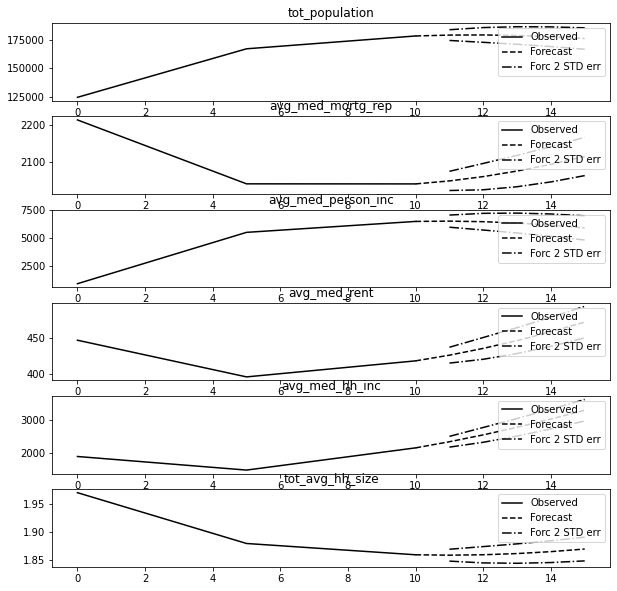

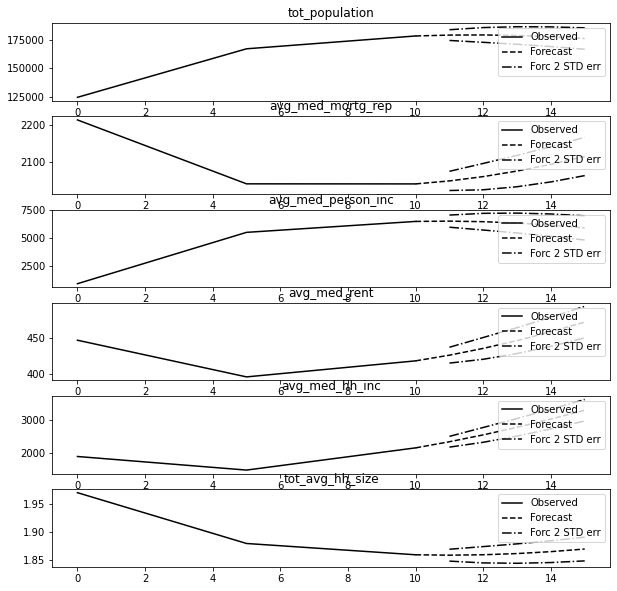

In [31]:
# change according to how many years in the future forecasting is required for
forecasting_steps = 5

impute_features = ['tot_population', 'avg_med_mortg_rep', 'avg_med_person_inc', 'avg_med_rent', 'avg_med_hh_inc', 'tot_avg_hh_size']
init_years = [11, 16, 21]
new_years = list(range(11, 22))

forecasted_dict = dict()

for i in [0]:
    data = census_df_postcode_agg.iloc[i]
    #print(census_df_postcode_agg.iloc[i])

    # interpolation 
    interpolated_dict = dict()
    interpolated_dict['date']= [f'20{year}' for year in new_years]

    for feature in impute_features:
        init_y = data[[f'{feature}_{init_years[0]}', f'{feature}_{init_years[1]}', f'{feature}_{init_years[2]}']].tolist()
        #print(init_y)

        interp_func = interp1d(init_years, init_y)
        new_y = list(interp_func(new_years))
        #print(new_y)

        interpolated_dict[feature] = new_y

    # creation of new dataframe
    interpolated_df = pd.DataFrame(interpolated_dict)
    

    # model
    interpolated_df['date'] = pd.to_datetime(interpolated_df['date'])
    interpolated_df = interpolated_df.set_index('date')

    model = VAR(endog=interpolated_df)
    model_fit = model.fit(trend='nc')

    forecasted_values = model_fit.forecast(interpolated_df.values[-1:], steps=forecasting_steps)
    
    forecasted_avg_med_rent = [row[3] for row in forecasted_values]

    forecasted_dict[int(data['postcode_2021'])] = forecasted_avg_med_rent

model_fit.plot_forecast(forecasting_steps)

In [19]:
# to calculate growth rate based on current medians derived from property data 
indexed_median_rent = median_rent.reset_index()
median_rent_dict = median_rent.to_dict()

growth_rate = dict()

for postcode in indexed_median_rent['Postcode']:

    current_value = median_rent_dict[str(postcode)]
    forecasted_2026 = forecasted_dict[int(postcode)][-1]

    # growth rate is defined as the proportion of the predicted value in 2026 
    # generated from the time regression model above against the current 
    # median rental price from the scaped data 

    rate = ((forecasted_2026 - current_value)/current_value)  

    growth_rate[int(postcode)] = rate

    

growth_rate_df = pd.DataFrame.from_dict(growth_rate, orient='index', columns = ['Growth Rate'])


In [20]:
growth_rate_df.sort_values(by = 'Growth Rate', ascending= False).head(10)

,Growth Rate
3028,0.788013
3027,0.677426
3737,0.659010
3125,0.543594
3071,0.537571
3085,0.432888
3025,0.407147
3196,0.395930
3915,0.379317
3129,0.371160
